<a href="https://colab.research.google.com/github/sugiyama404/forecast_sp500/blob/main/TIMESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neuralforecast > /dev/null 2>&1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from google.colab import drive
import time

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, TimesNet
from neuralforecast.utils import AirPassengersDF

In [ ]:
drive.mount('/content/drive/')
nov_dir = 'Colab Notebooks/dataset/reinforcement_learning/'
nov_train = '/content/drive/My Drive/' + nov_dir + 'sp500_train.csv'
nov_test = '/content/drive/My Drive/' + nov_dir + 'sp500_test.csv'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def preprocess_data(data_path):
    """
    CSVデータを読み込み、時系列分析のための前処理を行い、DataFrameを返す。
    Args:
        data_path (str): データを含むCSVファイルへのパス。
    Returns:
        pd.DataFrame: 時系列分析の準備ができた前処理済みの DataFrame。
    """
    df = pd.read_csv(data_path)
    try:
        df['ds'] = pd.to_datetime(df['Date'])
    except pd.errors.OutOfBoundsDatetime:
        print("Error: Date format might be invalid. Please check your data.")
        return None
    df['y'] = preprocessing.scale(df['SP500'])
    df['unique_id'] = 1.0
    df.drop(columns=['Date', 'SP500'], inplace=True)
    df = df.reindex(columns=['unique_id', 'ds', 'y'])
    return df

In [ ]:
df_train = preprocess_data(nov_train)
df_test = preprocess_data(nov_test)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  628 non-null    float64       
 1   ds         628 non-null    datetime64[ns]
 2   y          628 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 14.8 KB


In [ ]:
def add_predict_column(df, model, input_size):
    """
    df_testにpredict列を追加し返す関数
    Args:
        df_test: テストデータのDataFrame
        model: 予測モデル
    Returns:
        predict列を追加したDataFrame
    """
    df_predict = pd.DataFrame()
    for i in range(len(df) - input_size):
        arr = df[i:input_size+i]
        predict = model.predict(df=arr, verbose=True)
        df_predict = df_predict.append(predict)
    return df_predict

In [ ]:
input_size=100
network = [TimesNet(h=1, input_size=input_size, max_steps=100)]
model = NeuralForecast(models=network, freq='D')
model.fit(df=df_train)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
df_predict = add_predict_column(df_test, model, input_size)

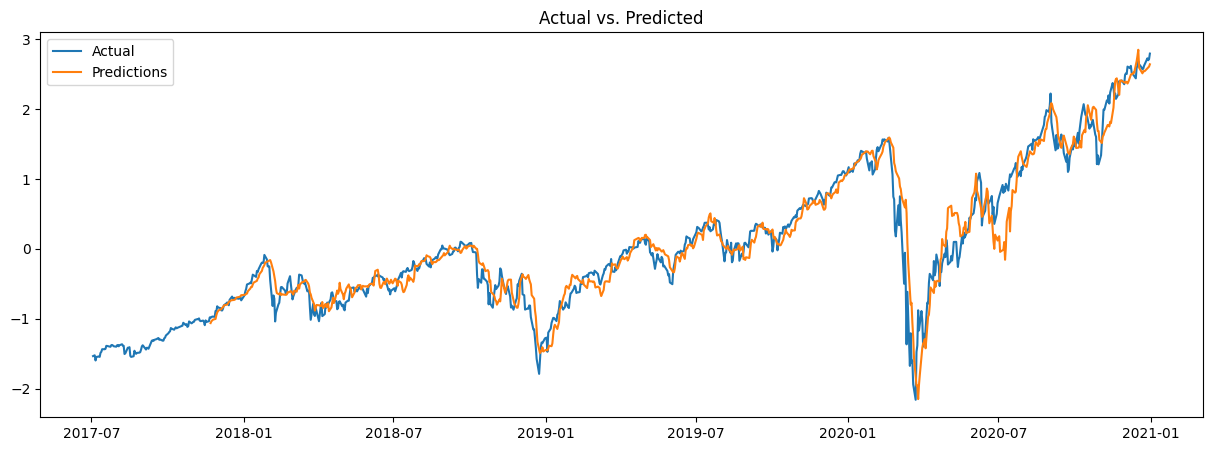

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df_test.ds, df_test.y, label="Actual")
plt.plot(df_predict.ds, df_predict.TimesNet, label="Predictions")
plt.title("Actual vs. Predicted")
plt.legend()
plt.show()